In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-17 06:27:49--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.005s  

2025-10-17 06:27:49 (16.0 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

df = pd.read_csv('course_lead_scoring.csv')

In [6]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [7]:
# Separate target
y = df['converted']
df = df.drop('converted', axis=1)

# Replace missing values
for c in df.columns:
    if df[c].dtype == 'object':
        df[c] = df[c].fillna('NA')
    else:
        df[c] = df[c].fillna(0.0)

# Split data
df_train, df_temp, y_train, y_temp = train_test_split(df, y, test_size=0.4, random_state=1)
df_val, df_test, y_val, y_test = train_test_split(df_temp, y_temp, test_size=0.5, random_state=1)

# Evaluate AUC for numerical features
num_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

for c in num_vars:
    auc = roc_auc_score(y_train, df_train[c])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[c])
    print(f"{c}: {auc:.3f}")


lead_score: 0.611
number_of_courses_viewed: 0.765
interaction_count: 0.727
annual_income: 0.545


In [8]:
# Prepare training data for DictVectorizer
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Train Logistic Regression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities
y_pred_val = model.predict_proba(X_val)[:, 1]

# Compute AUC
auc = roc_auc_score(y_val, y_pred_val)
print(f"Validation AUC: {auc:.3f}")


Validation AUC: 0.794


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


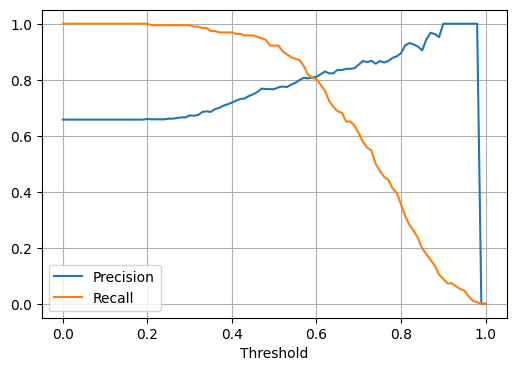

Precision and Recall intersect near threshold: 0.590
Precision and Recall intersect near threshold: 0.600
Precision and Recall intersect near threshold: 0.990
Precision and Recall intersect near threshold: 1.000


In [9]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    preds = (y_pred_val >= t).astype(int)
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find intersection threshold (where Precision ≈ Recall)
for t, p, r in zip(thresholds, precisions, recalls):
    if abs(p - r) < 0.01:
        print(f"Precision and Recall intersect near threshold: {t:.3f}")


In [10]:
f1_scores = []

for p, r in zip(precisions, recalls):
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best F1 threshold: {best_threshold:.3f}")


Best F1 threshold: 0.470


In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

df_full_train = pd.concat([df_train, df_val])
y_full_train = pd.concat([y_train, y_val])

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_k = df_full_train.iloc[train_idx]
    df_val_k = df_full_train.iloc[val_idx]
    y_train_k = y_full_train.iloc[train_idx]
    y_val_k = y_full_train.iloc[val_idx]
    
    dv = DictVectorizer(sparse=False)
    X_train_k = dv.fit_transform(df_train_k.to_dict(orient='records'))
    X_val_k = dv.transform(df_val_k.to_dict(orient='records'))
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_k, y_train_k)
    
    y_pred_k = model.predict_proba(X_val_k)[:, 1]
    auc = roc_auc_score(y_val_k, y_pred_k)
    scores.append(auc)

std_score = np.std(scores)
print(f"Standard deviation of AUC across folds: {std_score:.4f}")


Standard deviation of AUC across folds: 0.0220


In [12]:
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_k = df_full_train.iloc[train_idx]
        df_val_k = df_full_train.iloc[val_idx]
        y_train_k = y_full_train.iloc[train_idx]
        y_val_k = y_full_train.iloc[val_idx]

        dv = DictVectorizer(sparse=False)
        X_train_k = dv.fit_transform(df_train_k.to_dict(orient='records'))
        X_val_k = dv.transform(df_val_k.to_dict(orient='records'))

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_k, y_train_k)

        y_pred_k = model.predict_proba(X_val_k)[:, 1]
        auc = roc_auc_score(y_val_k, y_pred_k)
        scores.append(auc)

    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append((C, mean_score, std_score))

for C, mean, std in results:
    print(f"C={C}: mean={mean:.3f}, std={std:.3f}")

# Find best C
best = sorted(results, key=lambda x: (-x[1], x[2], x[0]))[0]
print(f"Best C: {best[0]} (mean={best[1]:.3f}, std={best[2]:.3f})")


C=1e-06: mean=0.543, std=0.025
C=0.001: mean=0.864, std=0.014
C=1: mean=0.825, std=0.022
Best C: 0.001 (mean=0.864, std=0.014)
